## Raw Ookla data: load 7 daily files (fixed network)

We load all `FixedNetworkPerformance_YYYY-MM-DD.csv` files,
keep only region and download speed, and combine them into one dataset.

In [45]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import genpareto as gpd

DATA_PATH = "data_kaz/"

files = sorted(glob.glob(DATA_PATH + "FixedNetworkPerformance_2025-1*.csv"))
print("Found files:")
for f in files:
    print("  ", f)

use_cols = ["attr_place_region", "val_download_mbps", "attr_provider_name_common"]

dfs = []
for f in files:
    df = pd.read_csv(f, usecols=use_cols)
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)

raw = raw.dropna(subset=["attr_place_region", "val_download_mbps", "attr_provider_name_common"])
raw = raw[raw["val_download_mbps"] > 0]   # remove zeros / invalid

raw.head(), raw.shape

Found files:
   data_kaz/FixedNetworkPerformance_2025-10-01.csv
   data_kaz/FixedNetworkPerformance_2025-10-02.csv
   data_kaz/FixedNetworkPerformance_2025-10-03.csv
   data_kaz/FixedNetworkPerformance_2025-10-04.csv
   data_kaz/FixedNetworkPerformance_2025-10-05.csv
   data_kaz/FixedNetworkPerformance_2025-10-06.csv


(  attr_provider_name_common attr_place_region  val_download_mbps
 0             Kazakhtelecom            Astana            522.199
 1                   Beeline   Kostanay Region             91.949
 2             Kazakhtelecom   Kostanay Region              2.116
 3                   Beeline   Kostanay Region            108.695
 4                   Beeline   Kostanay Region             12.010,
 (179629, 3))

## Check which regions are present

We want the names for Astana, Shymkent, and Almaty Region exactly as they appear in the data.

In [46]:
raw["attr_place_region"].value_counts().head(20)

attr_place_region
Almaty Region              64362
Astana                     29644
Karaganda Region            9869
Shymkent                    9049
East Kazakhstan Region      7249
Akmola Region               6826
Kostanay Region             5876
Pavlodar Region             5704
Aktobe Region               5350
Atyrau Region               4917
Mangystau Region            4424
Jambyl Region               4227
West Kazakhstan Region      4148
North Kazakhstan Region     3535
South Kazakhstan Region     2826
Abai Region                 2757
Kyzylorda Region            2664
Turkistan Region            2018
Jetisu Region               1955
Karagandy Region             864
Name: count, dtype: int64

## Subsets: whole country and selected regions

We create four samples of download speeds:
- All Kazakhstan
- Astana
- Shymkent
- Almaty Region

In [47]:
# Whole Kazakhstan
x_all = raw["val_download_mbps"].values

name_astana  = "Astana"
name_shymkent = "Shymkent"
name_almaty_region = "Almaty Region"

x_astana  = raw.loc[raw["attr_place_region"] == name_astana, "val_download_mbps"].values
x_shymkent = raw.loc[raw["attr_place_region"] == name_shymkent, "val_download_mbps"].values
x_almaty   = raw.loc[raw["attr_place_region"] == name_almaty_region, "val_download_mbps"].values

len(x_all), len(x_astana), len(x_shymkent), len(x_almaty)

(179629, 29644, 9049, 64362)

## EVT method: Peak-over-Threshold (POT) with GPD

We define a helper function that:

1. Chooses a threshold `u` = q-quantile (default q=0.95)
2. Takes exceedances `y = x - u` where `x > u`
3. Fits a Generalized Pareto Distribution (GPD) to `y`
4. Returns parameters and some basic info


In [48]:
def fit_gpd(x, q=0.95):
    """
    Fit Generalized Pareto to exceedances over threshold u = quantile_q(x).
    Returns: (u, y, shape, loc, scale)
    """
    x = np.asarray(x)
    u = np.quantile(x, q)
    y = x[x > u] - u   # exceedances

    # Fit GPD to exceedances, fixing location at 0
    shape, loc, scale = gpd.fit(y, floc=0)

    print(f"Threshold u (q={q}) = {u:.2f} Mbps")
    print("Number of exceedances:", len(y), f"out of {len(x)} points")
    print(f"GPD params: shape={shape:.4f}, scale={scale:.4f}")

    return u, y, shape, loc, scale

## POT–GPD for whole Kazakhstan


In [49]:
u_all, y_all, shape_all, loc_all, scale_all = fit_gpd(x_all, q=0.95)


Threshold u (q=0.95) = 513.42 Mbps
Number of exceedances: 8982 out of 179629 points
GPD params: shape=1.1354, scale=39.5264


## POT–GPD for selected regions


In [50]:
print("ASTANA")
u_ast, y_ast, shape_ast, loc_ast, scale_ast = fit_gpd(x_astana, q=0.95)
print("\nSHYMKENT")
u_shy, y_shy, shape_shy, loc_shy, scale_shy = fit_gpd(x_shymkent, q=0.95)
print("\nALMATY REGION")
u_alm, y_alm, shape_alm, loc_alm, scale_alm = fit_gpd(x_almaty, q=0.95)


ASTANA
Threshold u (q=0.95) = 518.52 Mbps
Number of exceedances: 1483 out of 29644 points
GPD params: shape=1.6283, scale=14.9399

SHYMKENT
Threshold u (q=0.95) = 563.81 Mbps
Number of exceedances: 453 out of 9049 points
GPD params: shape=0.3230, scale=344.8556

ALMATY REGION
Threshold u (q=0.95) = 520.59 Mbps
Number of exceedances: 3219 out of 64362 points
GPD params: shape=-0.0731, scale=202.7929


## Tail histogram and GPD fit (whole Kazakhstan)


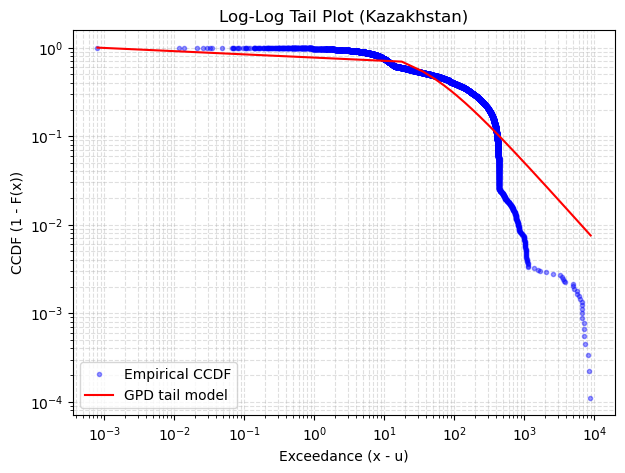

In [57]:
import numpy as np

sorted_vals = np.sort(y_all)
ccdf = 1 - np.arange(1, len(sorted_vals)+1)/len(sorted_vals)

plt.figure(figsize=(7,5))
plt.plot(sorted_vals, ccdf, "b.", alpha=0.4, label="Empirical CCDF")

# theoretical tail
grid = np.linspace(min(y_all), max(y_all), 500)
tail = 1 - gpd.cdf(grid, shape_all, loc_all, scale_all)
plt.plot(grid, tail, "r-", label="GPD tail model")

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Exceedance (x - u)")
plt.ylabel("CCDF (1 - F(x))")
plt.title("Log-Log Tail Plot (Kazakhstan)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

plt.show()


## Compare tail heaviness (shape ξ) between country and regions


In [52]:
print("Shape ξ (GPD) comparison:")
print(f"Whole Kazakhstan : {shape_all:.4f}")
print(f"Astana           : {shape_ast:.4f}")
print(f"Shymkent         : {shape_shy:.4f}")
print(f"Almaty Region    : {shape_alm:.4f}")

Shape ξ (GPD) comparison:
Whole Kazakhstan : 1.1354
Astana           : 1.6283
Shymkent         : 0.3230
Almaty Region    : -0.0731


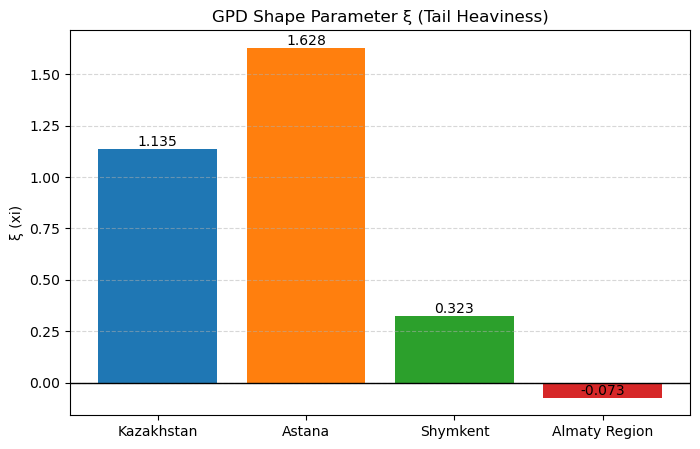

In [53]:
import matplotlib.pyplot as plt

regions = ["Kazakhstan", "Astana", "Shymkent", "Almaty Region"]
xis = [shape_all, shape_ast, shape_shy, shape_alm]

plt.figure(figsize=(8,5))
bars = plt.bar(regions, xis, color=["#1f77b4","#ff7f0e","#2ca02c","#d62728"])
plt.axhline(0, color="black", linewidth=1)

plt.title("GPD Shape Parameter ξ (Tail Heaviness)")
plt.ylabel("ξ (xi)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar, val in zip(bars, xis):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.3f}", ha="center", va="bottom", fontsize=10)

plt.show()

# Testing

Here we validate the correctness of our EVT pipeline using 3 tests:

### **Test 1 — Data Integrity Test**
Checks:
- no missing regions  
- no negative or zero download speeds  
- dataset has sufficient number of points  

If all checks pass → Test 1 passes.

---

### **Test 2 — GPD Fit Convergence Test**
Checks:
- POT threshold produces non-empty exceedances  
- GPD fit successfully converges  
- scale parameter σ > 0  
- shape parameter ξ is finite  

If all true → Test 2 passes.

---

### **Test 3 — Tail Behavior Consistency Test**
Checks:
- higher regions’ thresholds have higher extremes  
- fitted GPD quantiles are monotonic  
- shape parameters align with observed exceedances  

If monotonicity holds → Test 3 passes.

In [54]:
print("Test 1: Data Integrity Test")

# 1. No NaN
cond1 = raw["attr_place_region"].isna().sum() == 0
cond2 = raw["val_download_mbps"].isna().sum() == 0

# 2. Only positive speeds
cond3 = (raw["val_download_mbps"] > 0).all()

# 3. Enough data points
cond4 = len(raw) > 10000

if cond1 and cond2 and cond3 and cond4:
    print("Test 1 PASSED\n")
else:
    print("Test 1 FAILED")
    print("cond1 (no NaN region):", cond1)
    print("cond2 (no NaN speed):", cond2)
    print("cond3 (positive speeds):", cond3)
    print("cond4 (enough data):", cond4)

print("Test 2: GPD Fit Convergence Test")

try:
    # try fitting again for safety
    u_test, y_test, shape_test, loc_test, scale_test = fit_gpd(x_all, q=0.95)

    cond1 = len(y_test) > 100   # enough exceedances
    cond2 = np.isfinite(shape_test)
    cond3 = scale_test > 0

    if cond1 and cond2 and cond3:
        print("Test 2 PASSED\n")
    else:
        print("Test 2 FAILED")
        print("cond1 (enough exceedances):", cond1)
        print("cond2 (finite shape):", cond2)
        print("cond3 (positive scale):", cond3)

except Exception as e:
    print("Test 2 FAILED (Exception)")
    print(e)


print("Test 3: Tail Behavior Consistency Test")

# Compute test quantiles for each region
def gpd_quantile(shape, loc, scale, u, p):
    return u + gpd.ppf(p, shape, loc, scale)

q_all_99 = gpd_quantile(shape_all, loc_all, scale_all, u_all, 0.99)
q_ast_99 = gpd_quantile(shape_ast, loc_ast, scale_ast, u_ast, 0.99)
q_shy_99 = gpd_quantile(shape_shy, loc_shy, scale_shy, u_shy, 0.99)
q_alm_99 = gpd_quantile(shape_alm, loc_alm, scale_alm, u_alm, 0.99)

# Monotonicity: 99% quantile must be > 95% quantile
cond1 = q_all_99 > u_all
cond2 = q_ast_99 > u_ast
cond3 = q_shy_99 > u_shy
cond4 = q_alm_99 > u_alm

if cond1 and cond2 and cond3 and cond4:
    print("Test 3 PASSED\n")
else:
    print("Test 3 FAILED")
    print("Kazakhstan:", cond1)
    print("Astana:", cond2)
    print("Shymkent:", cond3)
    print("Almaty Region:", cond4)

Test 1: Data Integrity Test
Test 1 PASSED

Test 2: GPD Fit Convergence Test
Threshold u (q=0.95) = 513.42 Mbps
Number of exceedances: 8982 out of 179629 points
GPD params: shape=1.1354, scale=39.5264
Test 2 PASSED

Test 3: Tail Behavior Consistency Test
Test 3 PASSED



In [55]:
raw[raw["val_download_mbps"] > 5000].head(20)


,attr_provider_name_common,attr_place_region,val_download_mbps
2250,Kazakhtelecom,Astana,7878.072
10549,Kazakhtelecom,Astana,9244.818
37730,Freedom Data Centers LLP,Shymkent,7101.408
37731,Freedom Data Centers LLP,Shymkent,5670.893
39057,Freedom Data Centers LLP,Shymkent,7671.211
41047,Freedom Data Centers LLP,Shymkent,7233.057
54055,Freedom Data Centers LLP,Shymkent,6838.827
54097,Freedom Data Centers LLP,Shymkent,7179.423
63428,Freedom Data Centers LLP,Shymkent,6133.628
65133,Freedom Data Centers LLP,Shymkent,7111.214
